In [1]:
PROJECT_DIR = ''
APP_SYS_NAME = 'BGL'
#APP_SYS_NAME = 'Thunderbird'

In [2]:
BASE_DIR = PROJECT_DIR + 'output/'
RAW_DIR = PROJECT_DIR + 'raw_files/'

# Imports

In [3]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix , precision_score, recall_score, f1_score
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from scipy.spatial.distance import cosine
import warnings
import matplotlib.pyplot as plt
import sys
import subprocess
import random

random.seed(2)
sys.path.append(PROJECT_DIR) # this is done to make the import of ad_feature_extraction work
from ad_feature_extraction import parsers

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# Preprocessing

Input_data Shape: (220000, 78)
label
False    198431
True      21569
Name: count, dtype: int64


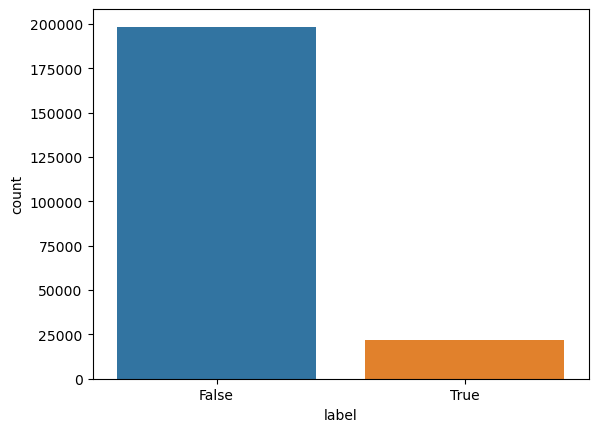

                 text
clusters label       
0        False    631
1        False      7
2        False   2021
3        False   8277
4        False   1563
5        False  80723
6        False   8890
7        False   5729
8        False   1757
9        False   4816
10       False   4457
11       False   2518
         True       1
12       False   2236
13       False   2101
14       False  19390
         True      61
15       False   1799
16       False   2235
17       False   1696
18       False   1783
19       False   2005
20       False      2
         True    4478
22       False   1431
23       False   1704
24       False   1461
25       False      5
         True    1995
26       False      3
         True    1797
27       False  12041
28       False   1543
29       False   1968
30       False   1169
31       True    1225
32       False   1626
33       True   12004
34       False   1000
35       False   1451
36       False   4466
38       False   1556
39       False   1018
40       F

In [4]:
input_data = pd.read_csv(BASE_DIR + APP_SYS_NAME + '_clusters2.csv')

print("Input_data Shape:",input_data.shape)
print(input_data['label'].value_counts())

sns.countplot(x=input_data['label'])
plt.show()

print(input_data[['clusters', 'label', 'text']].groupby(['clusters', 'label']).count())
print(f"Homogeneity Score: \n {homogeneity_score(input_data['label'], input_data['clusters'])}\n")
print(input_data[['cluster2', 'label', 'text']].groupby(['cluster2', 'label']).count())

In [5]:
le = LabelEncoder()
input_data['label'] = le.fit_transform(input_data['label']) # false:0 and true:1

X = input_data[['tfidf_text']].dropna()
y = input_data.loc[X.index,'label'].values

print("columns for the X file"+ str(X.columns))
print(X.shape,y.shape)

columns for the X fileIndex(['tfidf_text'], dtype='object')
(220000, 1) (220000,)


In [6]:
# do tfidf and kmeans on input_data and get homegeneity and completeness scores.
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X['tfidf_text'])
print('tfidf shape', X_tfidf.shape)

k = input_data['cluster2'].max() + 1
print('Using k = ', k)
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, batch_size=10000, random_state=0)
# KMeans(k, random_state=0)
kmeans.fit(X_tfidf)

pred = kmeans.predict(X_tfidf)
labels = y

print("_______________________________________________")
print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n") 

tfidf shape (220000, 2709)
Using k =  49
_______________________________________________
Completeness Score: 
 0.1108549275703622

Homogeneity Score: 
 0.9783973710210206



In [7]:
# count log lines within each cluster
output = X.copy()
output['cluster2'] = pred
output['label'] = input_data.loc[X.index, 'label']
print(output.groupby(['cluster2', 'label']).count())

                tfidf_text
cluster2 label            
0        0            2000
1        0           80723
2        0               7
         1           12004
3        0           13395
4        0            2829
5        0            4466
6        0           10929
7        0            5729
8        0            4789
9        0            4454
10       0             508
11       0            2317
12       0            1000
13       1            4478
14       0            1704
15       0            1456
16       0            1429
17       0            8890
18       0            2235
19       0            1461
20       0            1543
21       0            2518
         1               1
22       1            1792
24       0            2370
25       1            1225
26       0            1123
27       0            1161
28       0            1547
29       0            1451
30       0            1527
         1             523
31       0            2232
32       0            1121
3

# Use label to determine which clusters are anomalies

In [8]:
print(output.groupby(['cluster2', 'label']).count())
counts_by_label_df = output.groupby(['cluster2', 'label']).count().reset_index()
pos_df = counts_by_label_df[counts_by_label_df['label'] == 1]
neg_df = counts_by_label_df[counts_by_label_df['label'] == 0]
anomaly_clusters = []
normal_clusters = []
for _, row in pos_df.iterrows():
    cluster = row['cluster2']
    pos = row['tfidf_text']
    neg = neg_df[neg_df["cluster2"] == cluster]['tfidf_text'].sum()
    print(cluster, 'pos neg', pos, neg)
    if pos > neg:
        anomaly_clusters.append(cluster)

for _, row in neg_df.iterrows():
    cluster = row['cluster2']
    neg = row['tfidf_text']
    pos = pos_df[pos_df["cluster2"] == cluster]['tfidf_text'].sum()
    if neg >= pos:
        normal_clusters.append(cluster)

print('anomaly clusters', anomaly_clusters)
print('normal clusters', normal_clusters)

                tfidf_text
cluster2 label            
0        0            2000
1        0           80723
2        0               7
         1           12004
3        0           13395
4        0            2829
5        0            4466
6        0           10929
7        0            5729
8        0            4789
9        0            4454
10       0             508
11       0            2317
12       0            1000
13       1            4478
14       0            1704
15       0            1456
16       0            1429
17       0            8890
18       0            2235
19       0            1461
20       0            1543
21       0            2518
         1               1
22       1            1792
24       0            2370
25       1            1225
26       0            1123
27       0            1161
28       0            1547
29       0            1451
30       0            1527
         1             523
31       0            2232
32       0            1121
3

# Create summary report for clusters. Give example log line for each cluster.

In [9]:
summary_file_name = BASE_DIR + APP_SYS_NAME + '_cluster_summary.csv'
output_file = open(summary_file_name, 'w')
with output_file:
    writer = csv.writer(output_file)
    writer.writerow(['is_anomaly', 'anomaly_count', 'normal_count',
                     'cluster', 'pct_of_total',
                     'most_similar_sample', 'most_similar_distance',
                     'least_similar_sample', 'least_similar_distance'])
    
    def print_clusters(clusters, label):
        num_rows = X.shape[0]
        for ac in clusters:
            indices = X.index[pred == ac]
            rows_for_cluster = X_tfidf[pred == ac]
            centroid = kmeans.cluster_centers_[ac]
            least_distance = 0
            most_similar = None
            greatest_distance = 1
            least_similar = None
            for i in range(rows_for_cluster.shape[0]):
                row = np.asarray(rows_for_cluster[i].todense()).reshape(-1)
                distance = cosine(centroid, row)
                if most_similar is None or least_distance > distance:
                    least_distance = distance
                    most_similar = i
        
                if least_similar is None or greatest_distance < distance:
                    greatest_distance = distance
                    least_similar = i
                
            pct = round(np.count_nonzero(pred == ac) / num_rows, 2)
            writer.writerow([1 if label == 'anomaly' else 0,
                             pos_df[pos_df["cluster2"] == ac]['tfidf_text'].sum(),
                             neg_df[neg_df["cluster2"] == ac]['tfidf_text'].sum(),
                             ac, pct,
                             input_data.loc[indices[most_similar], 'text'], round(least_distance, 3),                  
                             input_data.loc[indices[least_similar], 'text'], round(greatest_distance, 3)])
    print_clusters(anomaly_clusters, 'anomaly')
    print_clusters(normal_clusters,  ' normal')
    
summary_df = pd.read_csv(summary_file_name)
summary_df

,is_anomaly,anomaly_count,normal_count,cluster,pct_of_total,most_similar_sample,most_similar_distance,least_similar_sample,least_similar_distance
0,1,12004,7,2,0.05,RAS KERNEL FATAL data TLB error interrupt,0.000,RAS KERNEL FATAL tlb error.......................,0.219
1,1,4478,0,13,0.02,RAS KERNEL FATAL data storage interrupt,0.000,RAS KERNEL FATAL data storage interrupt,0.000
2,1,1792,0,22,0.01,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000
3,1,1225,0,25,0.01,RAS APP FATAL ciod: Error reading message pref...,0.004,RAS APP FATAL ciod: Error reading message pref...,0.051
4,1,1477,0,35,0.01,RAS KERNEL FATAL rts: kernel terminated for re...,0.051,RAS KERNEL FATAL rts: kernel terminated for re...,0.582
5,0,0,2000,0,0.01,RAS KERNEL INFO 15 floating point alignment ex...,0.000,RAS KERNEL INFO 15 floating point alignment ex...,0.000
6,0,0,80723,1,0.37,RAS KERNEL INFO generating core.51,0.000,RAS KERNEL INFO generating core.51,0.000
7,0,0,13395,3,0.06,RAS KERNEL INFO iar 003a929c dear 01298a38,0.000,RAS KERNEL INFO iar 003a929c dear 01298a38,0.000
8,0,0,2829,4,0.01,RAS KERNEL INFO 1146800 double-hummer alignmen...,0.000,RAS KERNEL INFO 1146800 double-hummer alignmen...,0.000
9,0,0,4466,5,0.02,RAS KERNEL INFO 0 microseconds spent in the rb...,0.000,RAS KERNEL INFO 0 microseconds spent in the rb...,0.000


# Mispredictions

In [10]:
for ac in anomaly_clusters:
    indices = input_data.index[(pred == ac) & (input_data['label'] == 0)]
    if indices.size == 0:
        continue
    print('False Positives for cluster', ac, 'count', indices.size)
    print(np.unique(input_data.loc[indices, 'text'].values))
    print(np.unique(input_data.loc[indices, 'tfidf_text'].values))

for nc in normal_clusters:
    indices = input_data.index[(pred == nc) & (input_data['label'] == 1)]
    if indices.size == 0:
        continue
    print('False Negatives for cluster', nc, 'count', indices.size)
    print(np.unique(input_data.loc[indices, 'text'].values))
    print(np.unique(input_data.loc[indices, 'tfidf_text'].values))

False Positives for cluster 2 count 7
['RAS KERNEL FATAL tlb error.........................0']
['RAS KERNEL FATAL tlb error.........................0']
False Negatives for cluster 21 count 1
['RAS KERNEL FATAL program interrupt']
['RAS KERNEL FATAL program interrupt']
False Negatives for cluster 30 count 523
['RAS KERNEL FATAL MailboxMonitor::serviceMailboxes() lib_ido_error: -1019 socket closed'
 'RAS KERNEL FATAL rts panic! - stopping execution']
['RAS KERNEL FATAL MailboxMonitor::serviceMailboxes() :   '
 'RAS KERNEL FATAL rts panic! - stopping execution']
False Negatives for cluster 40 count 68
['RAS APP FATAL ciod: Error creating node map from file ./map-xyzt-8x8x16x1-2-mid: No child processes'
 'RAS BGLMASTER FAILURE ciodb exited abnormally due to signal: Aborted'
 'RAS BGLMASTER FAILURE mmcs_server exited normally with exit code 1'
 'RAS KERNEL FATAL DDR machine check register: 0x00000000 0x00010000'
 'RAS KERNEL FATAL machine check interrupt'
 'RAS KERNEL FATAL machine check in

# Use TFIDF and KMeans from above to predict anomalies in original raw file

In [11]:
cluster_to_label_map = np.zeros(k)
for c in anomaly_clusters:
    cluster_to_label_map[c] = 1
    
for c in normal_clusters:
    cluster_to_label_map[c] = 0

mispredictions_file_name = BASE_DIR + APP_SYS_NAME + '_mispredictions.csv'
output_file = open(summary_file_name, 'w')

def process_raw_file(raw_filename, parser):
    block_size = 100000 # entire dataset will not fit in memory, so do a block at a time
    file_path = raw_filename.split('/')
    with open(raw_filename, "r", encoding="utf8", errors='ignore') as raw_file:
        count = 0
        fp_total = tp_total = fn_total = 0
        row_block = []
        y_block = np.zeros(block_size)
        for line in raw_file:
            line = line.rstrip('\n')
            epochts,text,is_anomaly,filename = parser(file_path, line)
            y_block[count % block_size] = 1 if is_anomaly else 0
            count += 1
            row_block.append(text)
            
            if count % block_size == 0:
                X_block = tfidf.transform(row_block)
                block_clusters = kmeans.predict(X_block)
                block_pred = np.zeros(block_size)
                for i in range(block_clusters.shape[0]):
                    block_pred[i] = cluster_to_label_map[block_clusters[i]]
                        
                fp = (block_pred == 1) & (y_block == 0)
                tp = (block_pred == 1) & (y_block == 1)
                fn = (block_pred == 0) & (y_block == 1)
                fp_total += np.count_nonzero(fp)
                tp_total += np.count_nonzero(tp)
                fn_total += np.count_nonzero(fn)
                print(count, fp_total, tp_total, fn_total)
                row_block = []

            # Remove this condition to process full file.
            if count > 3000000: break
        print(raw_filename, 'precision', tp_total / (fp_total + tp_total))
        print(raw_filename, 'recall', tp_total / (fn_total + tp_total))

process_raw_file(RAW_DIR + APP_SYS_NAME + '/' + APP_SYS_NAME + '.log', parsers[APP_SYS_NAME])

100000 1 2517 92
200000 4 2641 128
300000 7 79506 135
400000 9 172224 143
500000 9 206704 143
600000 9 219328 143
700000 9 219328 143
800000 10 219328 2193
900000 19 222130 2773
1000000 20 222130 2791
1100000 21 222130 2798
1200000 22 222130 2847
1300000 23 222130 3043
1400000 27 222642 3052
1500000 27 222642 3052
1600000 33 223291 4651
1700000 33 223291 4651
1800000 33 223291 4651
1900000 33 223291 4652
2000000 35 223897 4836
2100000 38 223897 4847
2200000 38 223897 4847
2300000 39 225001 4847
2400000 41 225001 4851
2500000 49 226743 4947
2600000 49 226743 4947
2700000 51 226743 4951
2800000 55 226918 4961
2900000 55 226918 4961
3000000 74 227503 6407
raw_files/BGL/BGL.log precision 0.9996748353304595
raw_files/BGL/BGL.log recall 0.9726091231670301


# Compute precision, recall, homogeneity, confusion matrix

BGL Result:
Accuracy Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.997020      0.999666  0.997273       0.998343       0.997280
recall          0.999965      0.972507  0.997273       0.986236       0.997273
f1-score        0.998490      0.985900  0.997273       0.992195       0.997256
support    198431.000000  21569.000000  0.997273  220000.000000  220000.000000
_______________________________________________
Confusion Matrix: 
 [[198424      7]
 [   593  20976]]

_______________________________________________
Completeness Score: 
 0.1108549275703622

_______________________________________________
Homogeneity Score: 
 0.9783973710210206

_______________________________________________
F1 Score: 
 0.9858996051889453
_______________________________________________
Precision Score: 
 0.9996663966067769
_______________________________________________
Rec

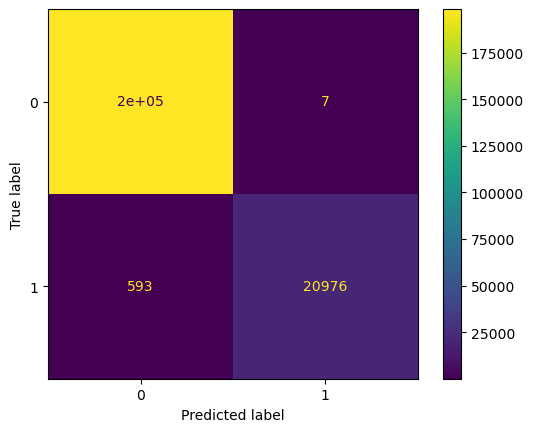

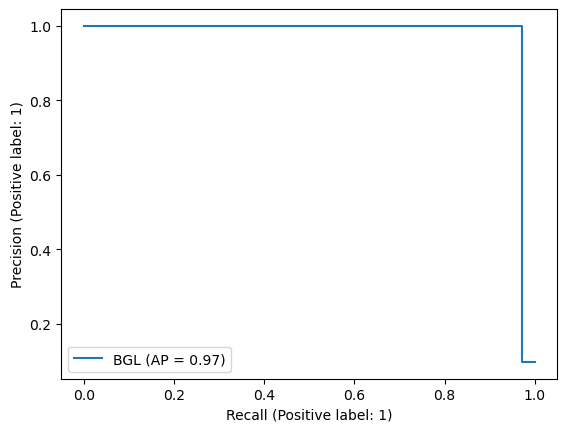

In [12]:
def report(report_name, pred, labels):
    label_pred = np.zeros(pred.size)
    for i in range(pred.size):
        label_pred[i] = cluster_to_label_map[pred[i]]
    kmeans_report = pd.DataFrame(classification_report(labels, label_pred, output_dict=True))
    print(f"{report_name} Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(labels, label_pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{kmeans_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(labels, label_pred)}\n")
    
    print("_______________________________________________")
    print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
    print("_______________________________________________")
    print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n")
    print("_______________________________________________")
    print(f'F1 Score: \n {f1_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Precision Score: \n {precision_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Recall Score: \n {recall_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Roc AUC Score: \n {roc_auc_score(labels, label_pred)}')
   
    ConfusionMatrixDisplay.from_predictions(labels, label_pred)
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(labels, label_pred, name=report_name)
    plt.show()

report(APP_SYS_NAME, pred, output.label.values)

# TSNE Scatterplot

220000


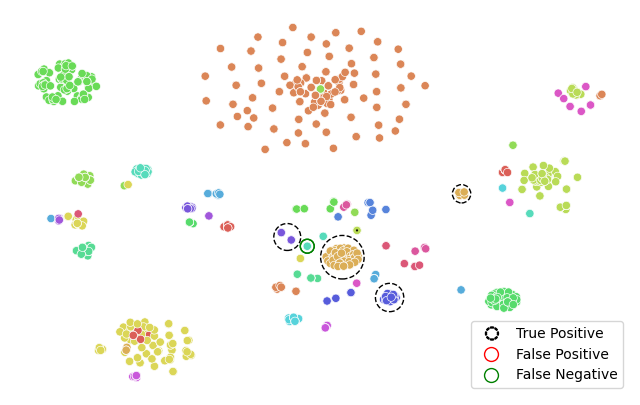

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

tfidf_tsne = TfidfVectorizer()
X_tfidf_tsne = tfidf_tsne.fit_transform(input_data.loc[X.index, 'text'])

print(output.shape[0])
output_sample = output.sample(1500, random_state=0)
X_tfidf_sample = X_tfidf_tsne[output_sample.index]

for perplexity in range(35, 36, 5):
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=1000, learning_rate='auto', random_state=1, init="random")
    tsne_result = tsne.fit_transform(np.asarray(X_tfidf_sample.todense()))
    plt.figure(figsize=(8,5))


    tsne_df = output_sample.copy()
    tsne_df['tsne_one'] = tsne_result[:,0]
    tsne_df['tsne_two'] = tsne_result[:,1]

    ax= sns.scatterplot(
        x='tsne_one', y='tsne_two',
        hue="cluster2",
        palette=sns.color_palette("hls", 20),
        #palette=sns.color_palette("blend:white,white"),
        data=tsne_df,
        legend=None,
        alpha=1,
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.set_frame_on(False)

    label_df = tsne_df[tsne_df['label'] == 1]
    
    legend_elements = [Line2D([0], [0], marker=u'$\u25CC$', color='white', markeredgecolor='black', label='True Positive', markerfacecolor='white', markersize=10, alpha=1),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='red', label='False Positive', markerfacecolor='white', markersize=10),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='green', label='False Negative', markerfacecolor='white', markersize=10)]
    ax.legend(handles=legend_elements, loc='lower right')

    tsne_centers = np.zeros((kmeans.cluster_centers_.shape[0], 2))
    tsne_radius = np.zeros(kmeans.cluster_centers_.shape[0])
    for i in range(kmeans.cluster_centers_.shape[0]):
        tsne_cluster = tsne_result[output_sample.cluster2 == i]
        if tsne_cluster.sum() == 0: continue
        tsne_centers[i] = np.mean(tsne_cluster, axis=0)
        tsne_radius[i] = np.max(np.max(tsne_cluster, axis=0) - np.min(tsne_cluster, axis=0))
    
    anomaly_tsne_centers = tsne_centers[anomaly_clusters]
    anomaly_tsne_radius = tsne_radius[anomaly_clusters]
    plt.scatter(anomaly_tsne_centers[:, 0], anomaly_tsne_centers[:, 1], s=anomaly_tsne_radius*200,
                facecolors='none', edgecolors='black', linestyle='dashed')
    
    false_negatives = tsne_result[output_sample.cluster2.isin(normal_clusters) & (output_sample.label == 1)]
    plt.scatter(false_negatives[:, 0], false_negatives[:, 1], s=100, facecolors='none', edgecolors='green')
    
    false_positives = tsne_result[output_sample.cluster2.isin(anomaly_clusters) & (output_sample.label == 0)]
    plt.scatter(false_positives[:, 0], false_positives[:, 1], s=100, facecolors='none', edgecolors='red')
    
    
    plt.show()


# Predictability

In [14]:
window_df = pd.DataFrame()
cluster_seq = input_data[['cluster2']].values
#cluster_seq = np.arange(50)
y_df = np.squeeze(cluster_seq)

print('uniq clusters', np.unique(y_df))

for w in range(1, 6):
    if w == 0:
        continue
    col = "w+" + str(w)
    padding = np.ones((1, w)) * -1
    window_df[col] = np.append(cluster_seq[w:], padding)

n = len(cluster_seq)
for w in range(1, 6):
    if w == 0:
        continue
    col = "w-" + str(w)
    padding = np.ones((1, w)) * -1
    window_df[col] = np.append(padding, cluster_seq[:n-w])

    
print(window_df.head(10))
print('window', window_df.shape, 'y_df', y_df.shape)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(window_df, y_df)
print('classes', gnb.classes_)

idx = np.ones(gnb.classes_.max() + 1).astype(int) * -1
for i, c in enumerate(gnb.classes_):
    idx[c] = i

print('idx', idx)

probs = gnb.predict_proba(window_df)
pred_probs = np.zeros(probs.shape[0])
for i in range(probs.shape[0]):
    col = idx[y_df[i]]
    pred_probs[i] = probs[i, col]


prob_totals = np.zeros(probs.shape[1])
prob_counts = np.zeros(probs.shape[1])
for i in range(probs.shape[1]):
    cls = gnb.classes_[i]
    prob_totals[i] = pred_probs[y_df == cls].sum()
    prob_counts[i] = np.count_nonzero(y_df == cls)
    #print('probs', i, cls, prob_totals[i], prob_counts[i])

predictiveness = prob_totals / prob_counts
print(predictiveness)
print(np.argsort(predictiveness))


for i in anomaly_clusters:
    print('anomaly cluster', i, 'predictiveness', predictiveness[idx[i]])

for i in normal_clusters:
    print('normal cluster', i, 'predictiveness', predictiveness[idx[i]])


uniq clusters [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48]
    w+1   w+2   w+3   w+4   w+5   w-1   w-2   w-3   w-4   w-5
0  33.0  33.0  33.0  33.0  33.0  -1.0  -1.0  -1.0  -1.0  -1.0
1  33.0  33.0  33.0  33.0  33.0  33.0  -1.0  -1.0  -1.0  -1.0
2  33.0  33.0  33.0  33.0  33.0  33.0  33.0  -1.0  -1.0  -1.0
3  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  -1.0  -1.0
4  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  -1.0
5  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0
6  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0
7  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0
8  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0
9  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0  33.0
window (220000, 10) y_df (220000,)
classes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

In [15]:
from scipy.stats import kurtosis, skew

num_clusters = input_data['cluster2'].max() + 1
stats_df = pd.DataFrame({'cluster': [j for j in range(num_clusters)]})

kurt_results = []
skew_results = []

offset = 0
block_size = 10000
while offset < len(input_data):
    block_df = input_data.iloc[offset:offset+block_size]
    mean_timestamp = block_df['timestamp'].mean()
    offset += block_size
    for k in range(num_clusters):
        block = block_df[block_df['cluster2'] == k]['timestamp'].values - mean_timestamp
        if len(block) == 0:
            b_kurt = b_skew = 0
        else:
            b_kurt = kurtosis(block)
            b_skew = skew(block)
        kurt_results.append((b_kurt, k))
        skew_results.append((b_skew, k))

kurt_results = sorted(kurt_results, reverse=True)
skew_results = sorted(skew_results, reverse=True)


min_timestamp = input_data['timestamp'].min()

def cluster_dist(k):
    result = input_data[input_data['cluster2'] == k]['timestamp'] - min_timestamp
    if result.size == 0:
        result = input_data['timestamp'] - min_timestamp
    np_result = np.asarray(result.values)
    mean = np_result.mean()
    std = np_result.std()
    np_result = (np_result - mean) / std
    stats_df.at[k, 'kurtosis'] = kurtosis(np_result)
    stats_df.at[k, 'skew'] = skew(np_result)

for k in range(num_clusters):
    cluster_dist(k)

stats_df.dropna()
print(input_data[['cluster2', 'label', 'clusters']].groupby(['cluster2', 'label']).count())
for col in stats_df.columns:
    print(col, np.argsort(stats_df[col].values))

print(stats_df)

                clusters
cluster2 label          
0        0          2000
1        0         80723
2        0             7
         1         12004
3        0         13395
4        0          2829
5        0          4466
6        0         10929
7        0          5729
8        0          4789
9        0          4454
10       0           508
11       0          2317
12       0          1000
13       1          4478
14       0          1704
15       0          1456
16       0          1429
17       0          8890
18       0          2235
19       0          1461
20       0          1543
21       0          2518
         1             1
22       1          1792
24       0          2370
25       1          1225
26       0          1123
27       0          1161
28       0          1547
29       0          1451
30       0          1527
         1           523
31       0          2232
32       0          1121
33       0          1756
34       0          1593
35       1          1477


In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

random_state=5

for ModelClass in [IsolationForest, SGDOneClassSVM]:
    model = ModelClass(random_state=random_state)
    model_pred = model.fit_predict(X_tfidf)
    model_pred[model_pred == 1] = 0
    model_pred[model_pred == -1] = 1
    model_name = type(model).__name__
    print("_______________________________________________")
    print(f"{model_name}:")
    print("Label counts", np.bincount(model_pred))
    print(f"Completeness Score: \n {completeness_score(model_pred, pred)}\n")
    print(f"Homogeneity Score: \n {homogeneity_score(model_pred, pred)}\n")
    

_______________________________________________
IsolationForest:
Label counts [220000]
Completeness Score: 
 0.0

Homogeneity Score: 
 1.0

_______________________________________________
SGDOneClassSVM:
Label counts [149696  70304]
Completeness Score: 
 0.20738556444130446

Homogeneity Score: 
 0.9370570182418796

